# Multi-Layer Perceptron

Haytham Mohamed

INFS 890 - Spring 2020

In [585]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

import tensorflow as tf
print(tf.__version__)

1.15.0


In [586]:
# network structure. 
# not to include the input layer
#net_layers = (8, 5)  # (11,9,8,4)

epochs=1000
batch_size=300

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.2


SCALE_TARGET = True
SCALE_FEATURES = True

select_features = False

TRAIN_MODEL = True

# trials
# 11 R2-> -0.12
# 11,16,8,4 R2-> 0.37
# 11,11,6 R2-> -0.2
# 11,8,6 R2->   0.316
# 11,11,8,4 R2->  0.37
# 11, 6 R2-> 0.37

In [587]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'
models_dir = home_dir + "/models/"

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


In [588]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [589]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.0300,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0300,0.0700,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.5000,0.1500,0.2400
1,0.0600,0.0200,0.0200,0.0200,0.0200,0.0100,0.0100,0.1800,0.1800,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.8900,0.1500,0.2400
2,0.0700,0.0300,0.0200,0.0300,0.0200,0.0100,0.0100,0.4400,0.2000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.3500,0.1500,0.2400
3,0.0700,0.0300,0.0200,0.0200,0.0200,0.0100,0.0100,0.2300,0.1700,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.2600,0.1300,0.2400
4,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.2400,0.1400,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.2800,0.3600,0.2400


In [590]:
data.shape

(6766, 18)

In [591]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))

there are 17 features


# Feature Selection

In [592]:
feature_list = inputs.columns.values
if select_features:
    clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)
    sfm = SelectFromModel(
                clf,
                threshold='0.02*mean')

    selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = inputs.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    
    print("columns selected are {}".format(features))

    inputs = inputs[feature_list]
    inputs.head(2)

In [593]:
n_inputs = len(feature_list)
n_inputs


17

# Network Architecture

In [594]:
#net_layers = (11, 8, 5, 2)  # (11,9,8,4)
net_layers = ( 11,8,4)

# Scale Target Variable

In [595]:
# scale targets for better convergence
if SCALE_TARGET:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [596]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=True, random_state=365)

print("y_train {} , y_test {}".format(y_train.shape, y_test.shape))


y_train (6089, 1) , y_test (677, 1)


# Scaling Features

In [597]:
if SCALE_FEATURES:
    x_scaler = StandardScaler()
    x_train = x_scaler.fit_transform(x_train)  # fit on training data only
    x_test = x_scaler.transform(x_test)

## Function to build a model

In [598]:
def build_keras_model(nodes = net_layers):   # this does not work with KerasRegressor. interesting
    # create model
    model = Sequential()  
    
    if isinstance(nodes, int) or not nodes:
        model.add(Dense(1, input_dim=n_inputs, kernel_initializer='normal'))
    
    else:
        model.add(Dense(nodes[1], input_dim=n_inputs, kernel_initializer='normal', activation='relu'))
    
        layer = 0
        while layer < len(nodes):
            model.add(Dense(nodes[layer], kernel_initializer='normal', activation='relu'))
            layer = layer + 1
        
        #model.add(Dense(1, kernel_initializer='normal', activation='linear')) 
        model.add(Dense(1, kernel_initializer='normal', activation='linear'))  
    
    adam = Adam(lr=learning_rate, decay=decay)
    
    # or loss= 'mean_absolute_percentage_error'
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    
    return model


In [599]:
model = build_keras_model()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
mc = ModelCheckpoint(models_dir + 'best_mlp_model.h5'
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

if TRAIN_MODEL:
    history = model.fit(x_train, y_train
                    , epochs=epochs
                    , batch_size=batch_size
                    , verbose=1
                    , validation_split=validation_split
                    , shuffle=False
                    , callbacks=callbacks)

print ("Done..!")


Train on 4871 samples, validate on 1218 samples
Epoch 1/1000
4871/4871 [==============================] - 4s 899us/step - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.2077 - val_mean_squared_error: 0.2077

Epoch 00001: val_loss improved from inf to 0.20770, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 2/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.2065 - mean_squared_error: 0.2065 - val_loss: 0.1961 - val_mean_squared_error: 0.1961

Epoch 00002: val_loss improved from 0.20770 to 0.19613, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 3/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.1940 - mean_squared_error: 0.1940 - val_loss: 0.1815 - val_mean_squared_error: 0.1815

Epoch 00003: val_loss improved from 0.19613 to 0.18150, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best

4871/4871 [==============================] - 0s 13us/step - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.0537 - val_mean_squared_error: 0.0537

Epoch 00051: val_loss improved from 0.05429 to 0.05368, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 52/1000
4871/4871 [==============================] - 0s 14us/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0531 - val_mean_squared_error: 0.0531

Epoch 00052: val_loss improved from 0.05368 to 0.05306, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 53/1000
4871/4871 [==============================] - 0s 13us/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0524 - val_mean_squared_error: 0.0524

Epoch 00053: val_loss improved from 0.05306 to 0.05242, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 54/1000
4871/4871 [=================

4871/4871 [==============================] - 0s 13us/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0391 - val_mean_squared_error: 0.0391

Epoch 00101: val_loss improved from 0.03911 to 0.03911, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 102/1000
4871/4871 [==============================] - 0s 13us/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0391 - val_mean_squared_error: 0.0391

Epoch 00102: val_loss improved from 0.03911 to 0.03910, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 103/1000
4871/4871 [==============================] - 0s 14us/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0391 - val_mean_squared_error: 0.0391

Epoch 00103: val_loss improved from 0.03910 to 0.03909, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 104/1000
4871/4871 [==============

4871/4871 [==============================] - 0s 17us/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0385 - val_mean_squared_error: 0.0385

Epoch 00151: val_loss improved from 0.03856 to 0.03855, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 152/1000
4871/4871 [==============================] - 0s 14us/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0385 - val_mean_squared_error: 0.0385

Epoch 00152: val_loss improved from 0.03855 to 0.03854, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 153/1000
4871/4871 [==============================] - 0s 13us/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0385 - val_mean_squared_error: 0.0385

Epoch 00153: val_loss improved from 0.03854 to 0.03852, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 154/1000
4871/4871 [==============

4871/4871 [==============================] - 0s 17us/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0380 - val_mean_squared_error: 0.0380

Epoch 00201: val_loss improved from 0.03800 to 0.03799, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 202/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0380 - val_mean_squared_error: 0.0380

Epoch 00202: val_loss improved from 0.03799 to 0.03798, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 203/1000
4871/4871 [==============================] - 0s 13us/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0380 - val_mean_squared_error: 0.0380

Epoch 00203: val_loss improved from 0.03798 to 0.03797, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 204/1000
4871/4871 [==============

4871/4871 [==============================] - 0s 15us/step - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0375 - val_mean_squared_error: 0.0375

Epoch 00251: val_loss improved from 0.03752 to 0.03751, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 252/1000
4871/4871 [==============================] - 0s 14us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0375 - val_mean_squared_error: 0.0375

Epoch 00252: val_loss improved from 0.03751 to 0.03750, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 253/1000
4871/4871 [==============================] - 0s 13us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0375 - val_mean_squared_error: 0.0375

Epoch 00253: val_loss improved from 0.03750 to 0.03749, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 254/1000
4871/4871 [==============

4871/4871 [==============================] - 0s 13us/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0371 - val_mean_squared_error: 0.0371

Epoch 00301: val_loss improved from 0.03714 to 0.03713, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 302/1000
4871/4871 [==============================] - 0s 13us/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0371 - val_mean_squared_error: 0.0371

Epoch 00302: val_loss improved from 0.03713 to 0.03713, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 303/1000
4871/4871 [==============================] - 0s 14us/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0371 - val_mean_squared_error: 0.0371

Epoch 00303: val_loss improved from 0.03713 to 0.03712, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 304/1000
4871/4871 [==============

4871/4871 [==============================] - 0s 17us/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0368 - val_mean_squared_error: 0.0368

Epoch 00351: val_loss improved from 0.03684 to 0.03684, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 352/1000
4871/4871 [==============================] - 0s 19us/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0368 - val_mean_squared_error: 0.0368

Epoch 00352: val_loss improved from 0.03684 to 0.03683, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 353/1000
4871/4871 [==============================] - 0s 17us/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0368 - val_mean_squared_error: 0.0368

Epoch 00353: val_loss improved from 0.03683 to 0.03683, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 354/1000
4871/4871 [==============

4871/4871 [==============================] - 0s 19us/step - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0366 - val_mean_squared_error: 0.0366

Epoch 00401: val_loss improved from 0.03662 to 0.03662, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 402/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0366 - val_mean_squared_error: 0.0366

Epoch 00402: val_loss improved from 0.03662 to 0.03661, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 403/1000
4871/4871 [==============================] - 0s 17us/step - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0366 - val_mean_squared_error: 0.0366

Epoch 00403: val_loss improved from 0.03661 to 0.03661, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 404/1000
4871/4871 [==============

4871/4871 [==============================] - 0s 18us/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0364 - val_mean_squared_error: 0.0364

Epoch 00451: val_loss improved from 0.03641 to 0.03641, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 452/1000
4871/4871 [==============================] - 0s 21us/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0364 - val_mean_squared_error: 0.0364

Epoch 00452: val_loss improved from 0.03641 to 0.03640, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 453/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0364 - val_mean_squared_error: 0.0364

Epoch 00453: val_loss improved from 0.03640 to 0.03640, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 454/1000
4871/4871 [==============

Epoch 502/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0362 - val_mean_squared_error: 0.0362

Epoch 00502: val_loss improved from 0.03624 to 0.03624, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 503/1000
4871/4871 [==============================] - 0s 17us/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0362 - val_mean_squared_error: 0.0362

Epoch 00503: val_loss improved from 0.03624 to 0.03624, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 504/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0298 - mean_squared_error: 0.0298 - val_loss: 0.0362 - val_mean_squared_error: 0.0362

Epoch 00504: val_loss improved from 0.03624 to 0.03623, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 505/1000
4871/4871 

Epoch 553/1000
4871/4871 [==============================] - 0s 17us/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0362 - val_mean_squared_error: 0.0362

Epoch 00553: val_loss improved from 0.03616 to 0.03616, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 554/1000
4871/4871 [==============================] - 0s 17us/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0362 - val_mean_squared_error: 0.0362

Epoch 00554: val_loss improved from 0.03616 to 0.03616, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 555/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0362 - val_mean_squared_error: 0.0362

Epoch 00555: val_loss did not improve from 0.03616
Epoch 556/1000
4871/4871 [==============================] - 0s 18us/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 

Epoch 579/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00579: val_loss improved from 0.03613 to 0.03613, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 580/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00580: val_loss improved from 0.03613 to 0.03613, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 581/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00581: val_loss improved from 0.03613 to 0.03613, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 582/1000
4871/4871 

Epoch 605/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00605: val_loss improved from 0.03609 to 0.03609, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 606/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00606: val_loss improved from 0.03609 to 0.03609, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 607/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00607: val_loss did not improve from 0.03609
Epoch 608/1000
4871/4871 [==============================] - 0s 19us/step - loss: 0.0293 - mean_squared_error: 0.0293 - val_loss: 

Epoch 635/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00635: val_loss did not improve from 0.03607
Epoch 636/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00636: val_loss improved from 0.03607 to 0.03607, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 637/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00637: val_loss did not improve from 0.03607
Epoch 638/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0361 - val_mean_squared_error: 0.0361

Epoch 00638: val_loss improved from 0.03607 to 0.03606, saving 

Epoch 690/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0360 - val_mean_squared_error: 0.0360

Epoch 00690: val_loss improved from 0.03600 to 0.03599, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 691/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0360 - val_mean_squared_error: 0.0360

Epoch 00691: val_loss did not improve from 0.03599
Epoch 692/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0360 - val_mean_squared_error: 0.0360

Epoch 00692: val_loss improved from 0.03599 to 0.03599, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 693/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 

4871/4871 [==============================] - 0s 14us/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0359 - val_mean_squared_error: 0.0359

Epoch 00744: val_loss did not improve from 0.03591
Epoch 745/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0359 - val_mean_squared_error: 0.0359

Epoch 00745: val_loss improved from 0.03591 to 0.03591, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 746/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0359 - val_mean_squared_error: 0.0359

Epoch 00746: val_loss did not improve from 0.03591
Epoch 747/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0359 - val_mean_squared_error: 0.0359

Epoch 00747: val_loss improved from 0.03591 to 0.03591, saving model to /Users

Epoch 770/1000
4871/4871 [==============================] - 0s 14us/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0359 - val_mean_squared_error: 0.0359

Epoch 00770: val_loss improved from 0.03586 to 0.03585, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 771/1000
4871/4871 [==============================] - 0s 14us/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0358 - val_mean_squared_error: 0.0358

Epoch 00771: val_loss improved from 0.03585 to 0.03585, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 772/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0359 - val_mean_squared_error: 0.0359

Epoch 00772: val_loss did not improve from 0.03585
Epoch 773/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 

Epoch 796/1000
4871/4871 [==============================] - 0s 20us/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0358 - val_mean_squared_error: 0.0358

Epoch 00796: val_loss improved from 0.03577 to 0.03577, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 797/1000
4871/4871 [==============================] - 0s 18us/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0358 - val_mean_squared_error: 0.0358

Epoch 00797: val_loss improved from 0.03577 to 0.03577, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 798/1000
4871/4871 [==============================] - 0s 19us/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0358 - val_mean_squared_error: 0.0358

Epoch 00798: val_loss improved from 0.03577 to 0.03576, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 799/1000
4871/4871 


Epoch 00823: val_loss did not improve from 0.03572
Epoch 824/1000
4871/4871 [==============================] - 0s 48us/step - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0357 - val_mean_squared_error: 0.0357

Epoch 00824: val_loss did not improve from 0.03572
Epoch 825/1000
4871/4871 [==============================] - 0s 50us/step - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0357 - val_mean_squared_error: 0.0357

Epoch 00825: val_loss improved from 0.03572 to 0.03572, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 826/1000
4871/4871 [==============================] - 0s 40us/step - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0357 - val_mean_squared_error: 0.0357

Epoch 00826: val_loss improved from 0.03572 to 0.03571, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 827/1000
4871/4871 [==============================] - 0s 28us/step - lo

4871/4871 [==============================] - 0s 16us/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0357 - val_mean_squared_error: 0.0357

Epoch 00889: val_loss did not improve from 0.03567
Epoch 890/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0357 - val_mean_squared_error: 0.0357

Epoch 00890: val_loss improved from 0.03567 to 0.03567, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 891/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0357 - val_mean_squared_error: 0.0357

Epoch 00891: val_loss improved from 0.03567 to 0.03567, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 892/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0357 - val_me


Epoch 00918: val_loss did not improve from 0.03564
Epoch 919/1000
4871/4871 [==============================] - 0s 17us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00919: val_loss improved from 0.03564 to 0.03564, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 920/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00920: val_loss improved from 0.03564 to 0.03563, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 921/1000
4871/4871 [==============================] - 0s 15us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00921: val_loss did not improve from 0.03563
Epoch 922/1000
4871/4871 [==============================] - 0s 15us/step - lo

4871/4871 [==============================] - 0s 16us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00949: val_loss improved from 0.03560 to 0.03560, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 950/1000
4871/4871 [==============================] - 0s 18us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00950: val_loss did not improve from 0.03560
Epoch 951/1000
4871/4871 [==============================] - 0s 19us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00951: val_loss did not improve from 0.03560
Epoch 952/1000
4871/4871 [==============================] - 0s 16us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0356 - val_mean_squared_error: 0.0356

Epoch 00952: val_loss improved from 0.03560 to 0.03560, saving model to /Users

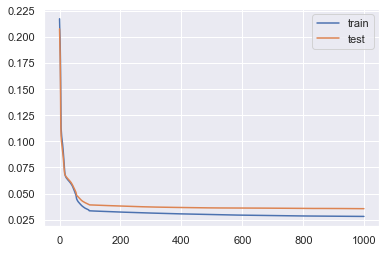

In [600]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [601]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 0.04  std: (0.01)


In [602]:
# load the saved model
saved_model = load_model(models_dir + 'best_mlp_model.h5')


In [603]:
# evaluate the model
train_loss, train_mse = saved_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_mse = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_mse, test_mse))

Train MSE: 0.030, Test MSE: 0.034


In [604]:
#regressor.fit(x_train, y_train)
y_hat = saved_model.predict(x_train)

#y_train = y_scaler.inverse_transform(y_train.reshape(-1,1))
#y_hat = y_scaler.inverse_transform(y_hat.reshape(-1,1))

In [605]:
y_train = y_train.reshape(-1)

In [606]:
y_train_together = pd.DataFrame(y_train, columns=['y_train_true'])
y_train_together['y_train_pred'] = y_hat
#y_train_together = y_train_together.reshape(-1,2)
y_train_together.head(5)

,y_train_true,y_train_pred
0,0.0226,0.0092
1,0.6702,0.4837
2,0.2022,0.4837
3,0.0226,0.0460
4,0.9753,0.9800


In [607]:
r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = 0.7734129244442283


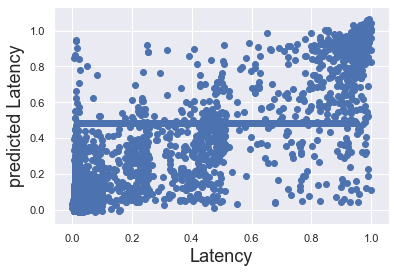

In [608]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

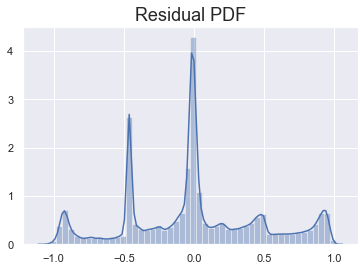

In [609]:
#y_train = y_train.values
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [610]:
# evaluation mean_absolute_percentage_error
train_error =  y_train - y_hat
train_error

mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Train Residual mean: %.2f std: %.2f  min; %.2f max: %.2f" \
      % (mean_error, std_error, min_error, max_error))

Train Residual mean: -0.00 std: 0.48  min; -1.06 max: 1.01


### Testing

In [611]:
y_hat_test = saved_model.predict(x_test)

#y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
#y_hat_test = y_scaler.inverse_transform(y_hat_test.reshape(-1,1))



In [612]:
y_test = y_test.reshape(-1)

In [613]:
y_test_together = pd.DataFrame(y_test, columns=['y_test_true'])
y_test_together['y_test_pred'] = y_hat_test
y_test_together.head(5)

,y_test_true,y_test_pred
0,0.9599,0.6913
1,0.0781,0.2943
2,0.3936,0.0493
3,0.0216,0.0336
4,0.2950,0.1631


<function matplotlib.pyplot.show(*args, **kw)>

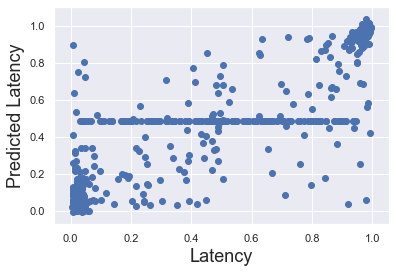

In [614]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

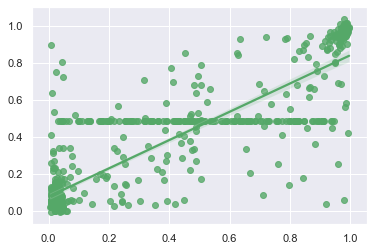

In [615]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [616]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
#y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.9964,2.6115
1,1.3422,1.0812
2,1.0506,1.4823
3,1.0342,1.0218
4,1.1772,1.3431


In [617]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.9964,2.6115,-0.6151,23.5529
1,1.3422,1.0812,0.2610,24.1375
2,1.0506,1.4823,-0.4318,29.1277
3,1.0342,1.0218,0.0123,1.2080
4,1.1772,1.3431,-0.1659,12.3500
...,...,...,...,...
672,1.0221,1.0229,-0.0007,0.0703
673,1.6221,1.2067,0.4154,34.4208
674,1.1093,1.0208,0.0886,8.6778
675,1.0316,1.0229,0.0088,0.8572


In [618]:
perf.describe()

,prediction,target,residual,difference%
count,677.0000,677.0000,677.0000,677.0000
mean,1.4535,1.4754,-0.0218,11.1277
std,0.5223,0.5961,0.3084,15.7485
min,0.9929,1.0052,-1.6084,0.0141
25%,1.0369,1.0229,-0.0413,1.3630
50%,1.1865,1.0625,0.0074,3.6853
75%,1.6221,1.8699,0.0535,15.5828
max,2.8118,2.7071,1.4361,142.4293


In [619]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
445,1.02,1.02,-0.00,0.01
31,1.02,1.02,0.00,0.02
562,1.62,1.62,0.00,0.03
467,1.05,1.05,0.00,0.04
80,1.04,1.04,0.00,0.06
221,1.02,1.02,0.00,0.06
672,1.02,1.02,-0.00,0.07
654,1.02,1.02,-0.00,0.07
668,1.02,1.02,0.00,0.08
167,1.02,1.02,0.00,0.09


# Prediction Accuracy

In [620]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = 0.7398822802136509


In [621]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.18467794471368654
